# M.SMART Хактатон

Хакатон **М.Видео** по обработке естественного языка и использованию искусственного интеллекта для работы с клиентами. 


**Цель:** Предсказание общей оценки товара


**Данные:** Данные: отзывы о товарах с сайта mvideo.ru, оценки, которые поставлены авторами отзыва, категория и брэнд товара. 

[Cкачать данные](http://hackathon.mvideo.ru/files/feedback.csv.rar)

## Анализ датасета

In [1]:
import pandas
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pandas.read_csv("X_train.csv")
data.head(2)

,sku,categoryLevel1Id,categoryLevel2Id,brandId,property,userName,reting,date,comment,commentNegative,commentPositive
0,20005023,401,4010201,826,"[{34: 'f982777489055c6563d68c005fd24aad'}, {36...",b2898a81b45310b30beb8fc0c0a9ce1e,2.0,2013-06-28,"2,5 года работала и все...устала! Лампочка гор...",NaN,NaN
1,20020647,403,4030101,1425,"[{34: '9ce895413ebdf6b6dcb69b07dc782591'}, {36...",538c73d64461e13907bb95c51c38bfbc,2.0,2010-07-04,Через 2 месяца после истечении гарантийного ср...,NaN,NaN


### Описание полей

* **sku** - Уникальный id товара
* **categoryLevel1Id** - id категории товара
* **categoryLevel2Id** - id подкатегории товара
* **brandId** - id бренда товара
* **userName** - id пользователя
* **date** - дата комментария
* **reting** - рейтинг товара, который поставил пользователь
* **comment** - текст комментария
* **commentNegative**/**commentNegative** - позитивная и негативные комментарии к товару

### Общая информация о датасете

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15587 entries, 0 to 15586
Data columns (total 11 columns):
sku                 15587 non-null int64
categoryLevel1Id    15587 non-null int64
categoryLevel2Id    15587 non-null int64
brandId             15587 non-null int64
property            15587 non-null object
userName            15587 non-null object
reting              15587 non-null float64
date                15587 non-null object
comment             15587 non-null object
commentNegative     924 non-null object
commentPositive     923 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 1.3+ MB


In [4]:
print("Количество пользователей:", len(set(data["userName"].get_values())))
print("Количество товаров:", len(set(data["sku"].get_values())))
print("Количество брендов:", len(set(data["brandId"].get_values())))
comments_count = [data[data["userName"] == uid].shape[0] for uid in set(data["userName"].get_values())]
print("Среднее количество комментариев у одного пользователя:", np.mean(comments_count))
print("Медианное количество комментариев у одного пользователя:", np.median(comments_count))
print("Максимальное количество комментариев у одного пользователя:", np.max(comments_count))

Количество пользователей: 3232
Количество товаров: 2698
Количество брендов: 193
Среднее количество комментариев у одного пользователя: 4.82271039604
Медианное количество комментариев у одного пользователя: 1.0
Максимальное количество комментариев у одного пользователя: 630


Из информации выше можно сделать следущий вывод - брать **id о пользователя** в качестве дополнительных параметров не рациаонально. 
У нас уже очень много пользователей в комментариях *(более 3 тысяч)*,их количество будет расти на продакшен проекте, однако это не касается **id брендов**, поскольку их ограниченое количество и появляются они не с такой регулярностью.

Проверим корреляцию средней оценки пользователей с id бренда.

### Распределение оценки по брендам

In [5]:
brands = list(set(data["brandId"].get_values()))
mean_brand_reting = []
median_brand_reting = []

              
for brand in brands:
    brand_reting = data[data["brandId"] == brand]["reting"]
    mean_brand_reting.append(brand_reting.mean())
    median_brand_reting.append(brand_reting.median())

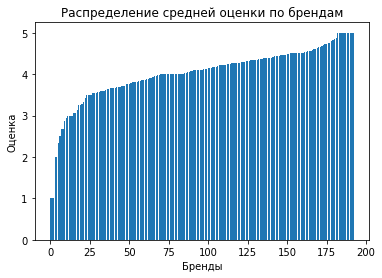

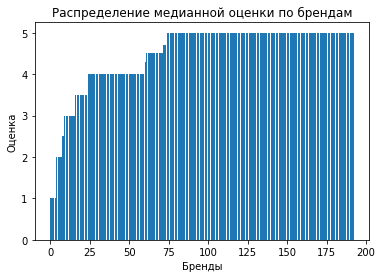

In [6]:
plt.title('Распределение средней оценки по брендам')
plt.xlabel('Бренды')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(mean_brand_reting))), sorted(mean_brand_reting))
plt.show()

plt.title('Распределение медианной оценки по брендам')
plt.xlabel('Бренды')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(median_brand_reting))), sorted(median_brand_reting))
plt.show()

Из графиков выше можно понять, что оценка товара сильно коррелируется с брендом и может послужить хорошим признаком для улучшения модели. Помимо этого, заметим, что медианные значения выглядят достаточно дискретно, что позволяет попробовать решить не только задачу в качестве регрессии, но задачу классификаци, для этого просмотрим распределение оценок пользователей по количеству.

### Распределение оценок пользователей

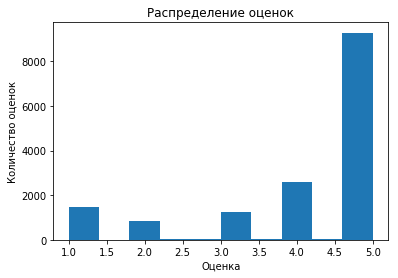

Все виды оценок: {1.0, 2.0, 3.0, 4.7, 4.0, 5.0, 2.3, 2.7, 4.3, 3.3, 3.7, 1.3, 1.7}
Количество видов оценок 13


In [7]:
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество оценок')
plt.hist(data["reting"])
plt.show()

print("Все виды оценок:", set(data["reting"].get_values().tolist()))
print("Количество видов оценок", len(set(data["reting"].get_values().tolist())))

Поскольку количество оценок конечное - мы можем привести задачу к банальной классификации на 12 классов и сравнить ее с регрессией.

### Распределение оценок по категориям товаров

Помимо данных о брендах у нас имеется информация о категориях и подкатегориях товаров, они могут нам значительно помочь поскольку средняя оценка на различные типы товаров может различаться.

In [8]:
categories = list(set(data["categoryLevel1Id"].get_values()))
mean_category_reting = []
median_category_reting = []

              
for category in categories:
    category_reting = data[data["categoryLevel1Id"] == category]["reting"]
    mean_category_reting.append(category_reting.mean())
    median_category_reting.append(category_reting.median())

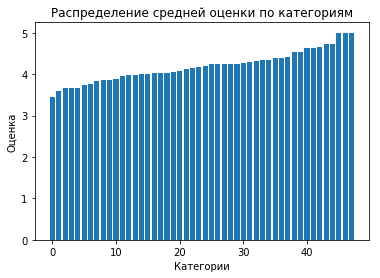

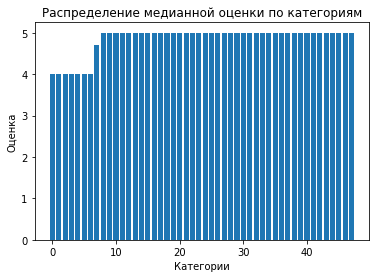

In [9]:
plt.title('Распределение средней оценки по категориям')
plt.xlabel('Категории')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(median_category_reting))), sorted(mean_category_reting))
plt.show()

plt.title('Распределение медианной оценки по категориям')
plt.xlabel('Категории')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(median_category_reting))), sorted(median_category_reting))
plt.show()

Как можно заметить из графиков, корреляция есть, но она не так выражена, как корреляция с брендами, однако помимо категорий у нас есть более точное разделение на подкатегории, проверим значения здесь.

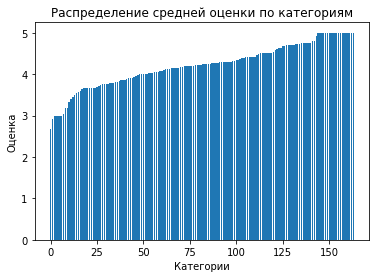

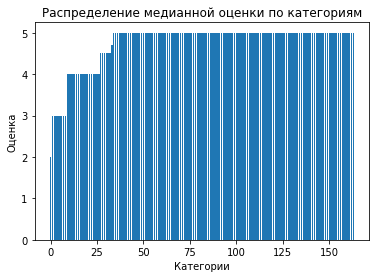

In [10]:
categories2 = list(set(data["categoryLevel2Id"].get_values()))
mean_category2_reting = []
median_category2_reting = []

              
for category in categories2:
    category_reting = data[data["categoryLevel2Id"] == category]["reting"]
    mean_category2_reting.append(category_reting.mean())
    median_category2_reting.append(category_reting.median())

plt.title('Распределение средней оценки по категориям')
plt.xlabel('Категории')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(mean_category2_reting))), sorted(mean_category2_reting))
plt.show()

plt.title('Распределение медианной оценки по категориям')
plt.xlabel('Категории')
plt.ylabel('Оценка')
plt.bar(list(range(0,len(median_category2_reting))), sorted(median_category2_reting))
plt.show()

Здесь же корреляция более выраженая и эти данные могут помочь в улучшении итоговой модели.

### Comment posetive/negative

По названию метки, можно подумать, что это бинарная метка тональности ответа, которых при этом очень мало
```
commentNegative     924 non-null object
commentPositive     923 non-null object
```

Однако, если мы взглянем внутрь, то сможем понять, что это не совсем так.

In [11]:
data[~data["commentPositive"].isnull()][["commentPositive"]].head(10)

,commentPositive
13,Пользуюсь данной кофемолкой несколько месяцев ...
47,"купил в выходной, установил за 30 мин, еще чер..."
71,Решили с женой поставить водонагреватель в бан...
78,1 Ножки стоят отлично. Качания нет.Транспортир...
84,"Всем привет, хочу поделиться с вами моим мнени..."
98,"Чайником K711 пользуемся уже третий год, и по..."
104,срок владения изделием 3 года. Очень некачеств...
113,Нам попалась бракованная-не работало нижнее ко...
127,Фильтрами пользуюсь постоянно. Этот выглядит о...
131,"Пользуемся месяц, полет прекрасный.Кухня 14 кв..."


Это некоторый текст, который очень похож на обычные отзывы к товару, но если мы взглянем поближе, то увидим...

**CommentPositive**

In [12]:
data[~data["commentPositive"].isnull()][["commentPositive"]].head(10).get_values()[0][0]

'Пользуюсь данной кофемолкой несколько месяцев - очень довольна. при покупке прежде всего руководствовалась репутацией бренда, качеством изделия, ценой. При сравнении с другими марками эта оказалась самой выигрышной: мало шумная, высокая скорость, качество сборки изделия (ничего не болтается, не отваливается и т.п.) Дальнейшая эксплуатация приносит только удовольствие. Отличный помощник на кухне!'

** CommentNegative**

In [13]:
data[~data["commentPositive"].isnull()][["commentNegative"]].head(10).get_values()[0][0]

'практически нет. Брала для помола специй, в частности, семена кардамона в пыль не смалывает, есть мелкие частицы. Но зерна кофе, прочие семена мелет отлично.'

Да! Это описание положительных и отрицательных сторон девайса. 

Проведем простой эксперимент для проверки корреляции признаков: сравним распределение длины отрицательных сторон в зависимости от оценки товара.

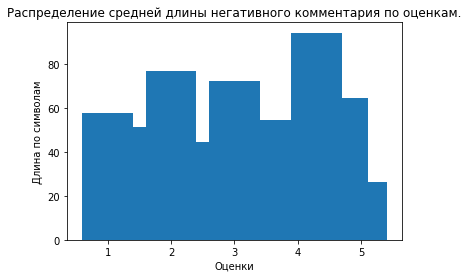

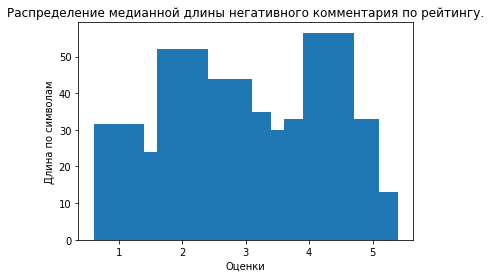

In [14]:
negative_comments = data[~data["commentPositive"].isnull()][["commentNegative"]].head(10).get_values()
negative_comments_len = [len(comment) for comment in negative_comments]
comments_reting = list(set(data[~data["commentNegative"].isnull()]["reting"].get_values().tolist()))
mean_reting = []
median_reting = []

for ret in comments_reting:
    negative_comments = data[(~data["commentNegative"].isnull()) & (data["reting"] == ret)]["commentNegative"].get_values()
    negative_comments_len = [len(comment) for comment in negative_comments]
    median_reting.append(np.median(negative_comments_len))
    mean_reting.append(np.mean(negative_comments_len))


plt.title('Распределение средней длины негативного комментария по оценкам.')
plt.xlabel('Оценки')
plt.ylabel('Длина по символам')
plt.bar(comments_reting, mean_reting)
plt.show()

plt.title('Распределение медианной длины негативного комментария по рейтингу.')
plt.xlabel('Оценки')
plt.ylabel('Длина по символам')
plt.bar(comments_reting, median_reting)
plt.show()

Если присмотреться к последнему графику, то можем увидеть, что центр масс гистограмы смещен в отрицательную сторону, это проявляется не так сильно в связи с тем, что длина по символам - не лучшая описательная характеристика, мы можем поробовать заменить ее другой, например: если мы начнем измерять не по длине строки, а по количеству слов, то увидим следующую картину.

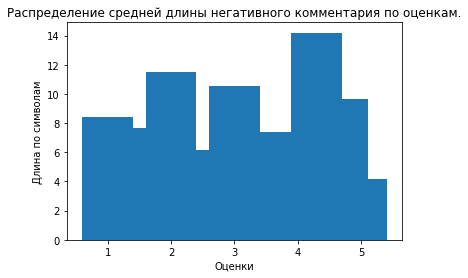

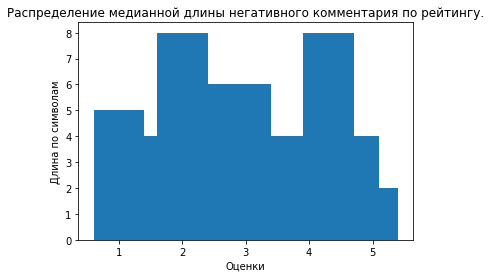

In [15]:
negative_comments_len = [len(comment) for comment in negative_comments]
comments_reting = list(set(data[~data["commentNegative"].isnull()]["reting"].get_values().tolist()))
mean_reting = []
median_reting = []

for ret in comments_reting:
    negative_comments = data[(~data["commentNegative"].isnull()) & (data["reting"] == ret)]["commentNegative"].get_values()
    negative_comments_len = [len(comment.split()) for comment in negative_comments]
    median_reting.append(np.median(negative_comments_len))
    mean_reting.append(np.mean(negative_comments_len))


plt.title('Распределение средней длины негативного комментария по оценкам.')
plt.xlabel('Оценки')
plt.ylabel('Длина по символам')
plt.bar(comments_reting, mean_reting)
plt.show()

plt.title('Распределение медианной длины негативного комментария по рейтингу.')
plt.xlabel('Оценки')
plt.ylabel('Длина по символам')
plt.bar(comments_reting, median_reting)
plt.show()

Здесь смещение в отрицательную сторону заметно на много больше. Дополнительной характеристикой рейтинга могла бы стать тональность данных отзывовов. Так же, мы можем попробовать просто добавить данный текст к общему отзыву.


Однако стоит заметить, что данных этого поля не так много, связано это по большей части с тем, что большая часть датасетя достаточно старая и такого поля попросту небыло, в связи чем данное поле может не дать сильного прироста, но при добавлении актуальных данных на продакшене, это может сильно помочь в работе реальной модели.

---

# Предобработка текста

Поскольку мы закончили с анализом датасета, можно переходить к извлечению и инженерингу фичей.

В первую очередь преобразуем данные из текста комментария, воспользуемся **TFIDF** и попробуес применить различные модели для задач классификации и регрессии, после чего добавим дополнительные параметры контекста, которые мы исследовали ранее.

### TfIdf

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
ru_stopwords = stopwords.words("russian")

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

Для уменьшения размерности итогового вектора добавим векторизатор нормализацию входного текста. С одной стороны, для этого можно было бы использовать стемминг, однаков в рамках русского языка стемминг показывает результаты хуже, чем в английском. По этому будем использовать лематизацию, т.е. приведение слов в начальную форму, например: *ЛЮДИ - ЧЕЛОВЕК*, чего невозможно достичь с помощью стемминга. Для лематизации, будем использовать библиотеку **pymorphy2**.

Так же мы будем использовать не только слова, но и **2х-граммы**, что позволит нам обрабатывать словосочитания вида: *"не нравится"*, чего бы мы не смогли сделать при обычном **tfidf**, и добавим в модель удаление **стоп-слов** русского языка.

In [17]:
class LemaTfidf(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (morph.parse(word)[0].normal_form for word in analyzer(doc))

tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=ru_stopwords, max_df=0.6)

Преобразуем **текст** комментариев в **вектор** и выделим итогове значение рейтинга отдельным вектором.

In [18]:
vectors = tfidf.fit_transform(data["comment"].get_values())
labels = data["reting"].get_values()

vectors.shape[1]

404692

Как видим, итоговый вектор получился очень большой (поскольку матрица очень разрежена) и есть риск переобучения, поэтому воспользуемся методами сжатия данных, а именно **PCA**. Итоговый вектор будет сжат до 1000мерного пространтсва.

А теперь, разделим выборку на две части и проведем предворительное обучение и посмотрим на результаты.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.33, random_state=42)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=800)
x_train = pca.fit_transform(x_train.toarray())

In [21]:
x_test = pca.transform(x_test.toarray())

## Тренеруем текстовые классификаторы

Настало время натренирорвать наши классификаторы на работу с текстом, для начала попробуем сделать это без использования признаков контекста, основываясь только на векторах входного текста. Таким образом мы сможем выявить лучшие модели для нашей задачи, а так же получить модель предсказания тональности, что нам поможет выловить полезные данные из полей "плюсы и минусы".

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Линейные методы

Начать можно с простых линейных методов, они могут показать достаточно хорошие результаты на этих данных. Как говорилось ранее попробуем решить задачу регрессии и классификации.

#### LineralRegression - регрессия

In [23]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

lr_pred = lr.predict(x_test)
lr_score = mean_squared_error(lr_pred, y_test), mean_absolute_error(lr_pred, y_test)

print("MSE: %s\nMAE: %s"%lr_score)

MSE: 1.09222362719
MAE: 0.804004546734


#### ElasticNet - регрессия

Помимо линейной регрессии, которая сильно склонная к переобучению, воспользуемся ElasticNet, не обладающий таким недостатком. 

In [24]:
from sklearn.linear_model import ElasticNet

eln = ElasticNet(alpha=0.1)
eln.fit(x_train, y_train)

eln_pred = eln.predict(x_test)
eln_score = mean_squared_error(eln_pred, y_test), mean_absolute_error(eln_pred, y_test)

print("MSE: %s\nMAE: %s"%eln_score)

MSE: 1.76602919931
MAE: 1.05844295791


#### LogisticRegression - классификация

Ну и конечно перейдем к решению задачи классификации, для этого воспользуемся **Логистической Регрессией**, которая на самом деле классификация :D. Но возьмем мы не простой logreg, а добавим в качестве оптимизатора **SGD** (стахостический градиентный спуск).

Заметьте, в конечном итоге мы проверяем алгоритм не с помощью метрик классификации, а с помощью метрик регрессии, поскольку для нас выбор класса *1* и *5* вместо класса *2* имеют разный вес.

In [25]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_tr = le.fit_transform(y_train)

lgr = SGDClassifier(loss="log")
lgr.fit(x_train, y_tr)

lgr_pred = le.classes_[lgr.predict(x_test)]
lgr_score = mean_squared_error(lgr_pred, y_test), mean_absolute_error(lgr_pred, y_test)

print("MSE: %s\nMAE: %s"%lgr_score)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


MSE: 2.52808903577
MAE: 0.885711508554


### Деревья решений

Для деревьев решений, будем использовать не средства **sklearn**, а фреймворк от Microsoft **ligthgbm**. Удобство его использования в нашей задаче заключается в следующем: 
* Обучение модели происходит намного быстрее, чем в Xgboost
* Модель работает на много точнее, чем встроеные решения Sklearn
* Есть возможность запуска обучения на GPU
* Присутвует встроенная возможность использоваения категориалных фич, что исключает dummy-кодирование

In [26]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, y_train)
test_data = lgb.Dataset(x_test, y_test)

train_data_cls = lgb.Dataset(x_train, le.transform(y_train))
test_data_cls = lgb.Dataset(x_test, le.transform(y_test))

#### GradientBoosting - регрессия

In [30]:
gb_r_model_params = {
    "device": "cpu",
    "application": "regression_l2",
    "boosting": "gbdt",
    "num_leaves": 120,
    "max_depth": 10,
    "learning_rate": 0.1,
    "num_iterations": 100
}

num_round = 10


gbm_r = lgb.train(gb_r_model_params, train_data, num_round, valid_sets=[test_data])

gbm_r_pred = gb_r.predict(x_test, num_iteration=gbm_r.best_iteration)
gbm_r_score = mean_squared_error(gbm_r_pred, y_test), mean_absolute_error(gbm_r_pred, y_test)

print("MSE: %s\nMAE: %s"%gbm_r_score)

/usr/lib/python3.5/site-packages/lightgbm/engine.py:100: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


MSE: 1.17536849022
MAE: 0.774010434326


#### GradientBoosting - классификация

In [37]:
gbm_c_model_params = {
    "device": "cpu",
    "application": "multiclass",
    "boosting": "gbdt",
    "num_leaves": 130,
    "max_depth": 7,
    "learning_rate": 0.1,
    "num_iterations": 100,
    "num_class": len(set(y_train))
}

num_round = 10


gbm_c = lgb.train(gbm_c_model_params, train_data_cls, num_round, valid_sets=[test_data_cls])
# gb_r.save_model('rfr_r.txt', num_iteration=gb_r.best_iteration)

gbm_c_pred = gbm_c.predict(x_test, num_iteration=gb_r.best_iteration)
gbm_c_pred = le.classes_[np.array(list(map(np.argmax, gbm_c_pred)))]

gbm_c_score = mean_squared_error(gbm_c_pred, y_test), mean_absolute_error(gbm_c_pred, y_test)

print("MSE: %s\nMAE: %s"%gbm_c_score)

/usr/lib/python3.5/site-packages/lightgbm/engine.py:100: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


MSE: 1.93575427683
MAE: 0.74000777605


### Результаты

In [38]:
print("Lineral regression: %s MSE, %s MAE" % lr_score)
print("ElasticNet regression: %s MSE, %s MAE" % eln_score)
print("LogisticRegrssion classification: %s MSE, %s MAE" % lgr_score)
print()
print("GradientBoosting regression: %s MSE, %s MAE" % gbm_r_score)
print("GradientBoosting classification: %s MSE, %s MAE" % gbm_c_score)

Lineral regression: 1.09222362719 MSE, 0.804004546734 MAE
ElasticNet regression: 1.76602919931 MSE, 1.05844295791 MAE
LogisticRegrssion classification: 2.52808903577 MSE, 0.885711508554 MAE

GradientBoosting regression: 1.17536849022 MSE, 0.774010434326 MAE
GradientBoosting classification: 1.93575427683 MSE, 0.74000777605 MAE


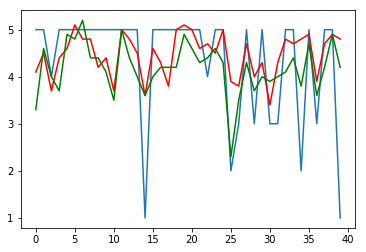

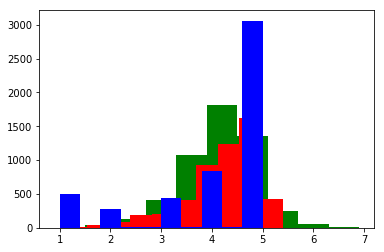

In [56]:
n = 40
plt.plot(y_test[:n])
plt.plot(gbm_r_pred.round(1)[:n], color="red")
plt.plot(lr_pred.round(1)[:n], color="green")
plt.show()

plt.hist(lr_pred.round(1), color="green")
plt.hist(gbm_r_pred.round(1), color="red")
plt.hist(y_test.round(1), color="blue")
plt.show()